    Interest_1_W_Binned  total_purchase_amt  total_redeem_amt
0                     9        23344.101356      22042.035801
1                     8        33988.586226      26575.083379
2                    52        75337.194846      34242.909812
3                    40        36504.130468      29721.253800
4                     7        36981.355078      48066.389440
5                    42        69962.536101      25829.059463
6                    65        48846.196320      34292.984319
7                    49        81334.029936      37121.771554
8                    35        39881.260027      27439.610896
9                    63        52850.783409      69730.219424
10                   10        58790.676207      59687.883653
11                    1        45036.738037      50894.096709
12                   46        74235.947735      32635.408794
13                   48        47483.894773      43228.640265
14                   83        27578.780387      31660.272559
15      

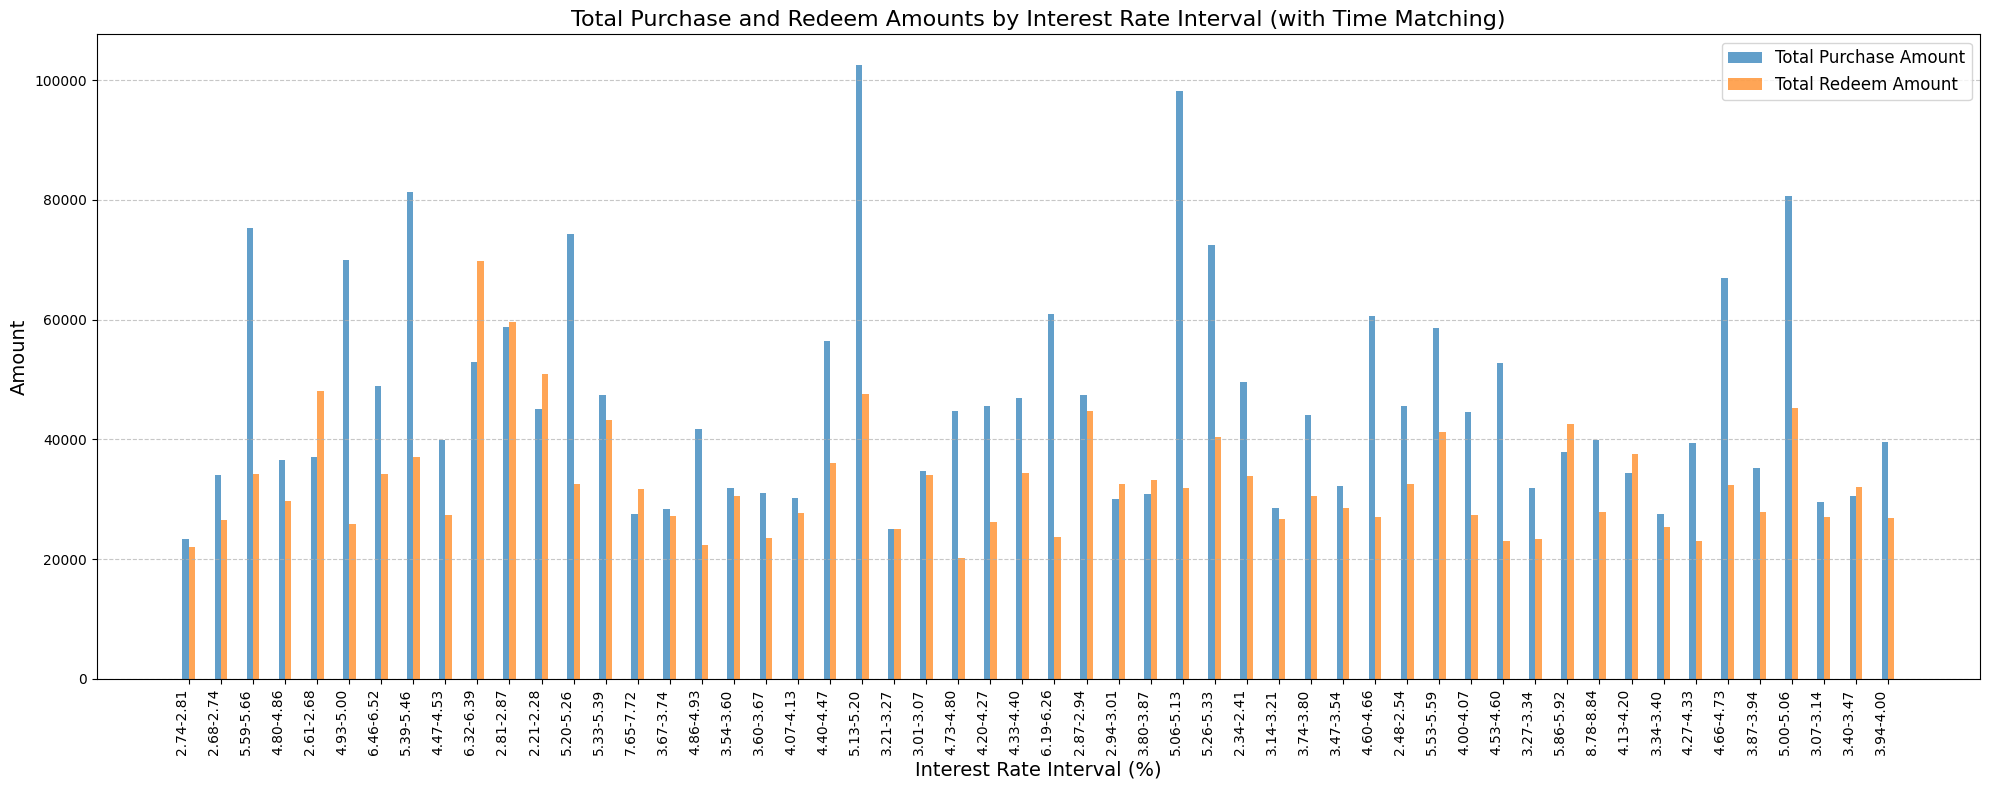

In [10]:
import cudf
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mfd_bank_shibor_df = cudf.read_csv('mfd_bank_shibor.csv')
user_balance_table_df = cudf.read_csv('user_balance_table.csv')

mfd_bank_shibor_df['mfd_date'] = cudf.to_datetime(mfd_bank_shibor_df['mfd_date'], format='%Y%m%d')
user_balance_table_df['report_date'] = cudf.to_datetime(user_balance_table_df['report_date'], format='%Y%m%d')

merged_df = user_balance_table_df.merge(
    mfd_bank_shibor_df,
    left_on='report_date',
    right_on='mfd_date',
    how='inner'
)

min_interest = merged_df['Interest_1_W'].min()
max_interest = merged_df['Interest_1_W'].max()

interest_bins = cp.linspace(min_interest, max_interest, 101)
interest_array = cp.asarray(merged_df['Interest_1_W'].to_numpy())
binned_array = cp.digitize(interest_array, interest_bins)
binned_numpy = binned_array.get()
merged_df['Interest_1_W_Binned'] = binned_numpy
result_df = merged_df.groupby('Interest_1_W_Binned')[['total_purchase_amt', 'total_redeem_amt']].mean().reset_index()
print(result_df)
result_df_pd = result_df.to_pandas()

bin_edges = cp.asnumpy(interest_bins)
def get_bin_label(bin_num):
    if bin_num <= 0:
        bin_num = 1
    elif bin_num > len(bin_edges) - 1:
        bin_num = len(bin_edges) - 1
    return f'{bin_edges[bin_num - 1]:.2f}-{bin_edges[bin_num]:.2f}'

result_df_pd['Interest_Rate_Interval'] = result_df_pd['Interest_1_W_Binned'].apply(get_bin_label)
plt.figure(figsize=(20, 8))
x = np.arange(len(result_df_pd))
width = 0.2
plt.bar(x - width/2, result_df_pd['total_purchase_amt'], width=width, label='Total Purchase Amount', alpha=0.7)
plt.bar(x + width/2, result_df_pd['total_redeem_amt'], width=width, label='Total Redeem Amount', alpha=0.7)
plt.xlabel('Interest Rate Interval (%)', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.title('Total Purchase and Redeem Amounts by Interest Rate Interval (with Time Matching)', fontsize=16)
plt.xticks(ticks=x, labels=result_df_pd['Interest_Rate_Interval'], rotation=90, ha='right', fontsize=10)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()